# 1. pib

## Variables

- consumo_privado
- inversiones
- gasto_publico
- exportaciones
- importaciones
- variacion


In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from itertools import product
from sklearn.model_selection import GridSearchCV
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from functools import partial
import joblib
import warnings
import tensorflow as tf

seed_value = 42
tf.random.set_seed(seed_value)
tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices([], 'GPU')
warnings.filterwarnings("ignore")

cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'data')
input_path = os.path.join(data_path, 'input')
output_path = os.path.join(data_path, 'output')
target_var = 'pib'

## Importación de datos

In [22]:
metadata_path = os.path.join(cwd_path,'metadatos.xlsx')
variables = pd.read_excel(metadata_path)

filtro_componente = (variables[target_var]
                     .fillna(0)
                     .astype(bool))
variables_componente = variables[filtro_componente].reset_index(drop=True)

input_files = {}
for idx, row in variables_componente.iterrows():
  input_files[row.variable] = [row.sector, row.subsector, f'{row.variable}.csv']

input_list = []
for name, path in input_files.items():
  file_path = os.path.join(input_path, *path)
  df_input = (pd
                .read_csv(file_path, sep=',')
                .rename(columns={'Fecha': 'fa', 'Valor': name})
                .assign(fa = lambda df: pd.to_datetime(df['fa'], dayfirst=True))
                .set_index('fa')
                )
  input_list.append(df_input)

df = pd.concat(input_list, axis=1, join='outer')
output_filepath = os.path.join(output_path, f'{target_var}_dataset.xlsx')
df.to_excel(output_filepath)

## Procesamiento

In [39]:
def data_processing(df, target_var, t_samples, keep_all):
    df_shifted = df[[target_var]].copy()
    for n in range(1, t_samples + 1):
        for col in df.columns:
            df_shifted[f'{col}_t_{n}'] = df[col].shift(n)
    df_shifted = df_shifted.dropna()

    for col in df.columns:
        df_shifted[f'{col}_prom_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].mean(axis=1)
        df_shifted[f'{col}_desv_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].std(axis=1)
        df_shifted[f'{col}_min_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].min(axis=1)
        df_shifted[f'{col}_max_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].max(axis=1)
        df_shifted[f'{col}_sum_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].sum(axis=1)

    if not keep_all:
        columns_to_keep = [target_var] + [f'{col}_t_{1}' for col in df.columns] + \
                          [f'{col}_{agg}_{t_samples}' for col in df.columns for agg in ['prom', 'desv', 'min', 'max', 'sum']]
        df_shifted = df_shifted[columns_to_keep]

    return df_shifted

df_shifted = data_processing(df, target_var, 4, False)

X = df_shifted.drop(columns=[target_var])
y = df_shifted[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_scaled = pd.DataFrame(
#     X_train_scaled, 
#     index=X_train.index,
#     columns=X_train.columns
# )

# X_test_scaled = pd.DataFrame(
#     X_test_scaled, 
#     index=X_test.index, 
#     columns=X_test.columns
# )

## Entrenamiento

In [40]:
def optimize_arima(y_train, X_train, p_values, d_values, q_values):
    best_score, best_params, best_model = float("inf"), None, None
    
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(y_train, order=(p, d, q), exog=X_train).fit()
            if model.aic < best_score:
                best_score, best_params, best_model = model.aic, (p, d, q), model
        except Exception as e:
            continue

    return best_model, best_params

def arquitectura_ann(cant_capas, cant_neurons, learning_rate, input_dim):
    model = Sequential([Input(shape=(input_dim,))])
    for _ in range(cant_capas):
        model.add(Dense(cant_neurons, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def optimizar_ann(trial, X_train, y_train, X_test, y_test):
    cant_capas = trial.suggest_int('cant_capas', 2, 5)
    cant_neurons = trial.suggest_int('cant_neurons', 50, 100)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    model = arquitectura_ann(cant_capas, cant_neurons, learning_rate, X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test),
        epochs=100, batch_size=batch_size, verbose=0, callbacks=[early_stopping]
    )
    return min(history.history['val_loss'])

In [ ]:
def train_models(X_train, X_test, y_train, y_test):
    seed_value = 42
    best_models = {}

    p_values = range(0, 4)
    model_ar, best_ar_params = optimize_arima(y_train.asfreq('QE'), X_train.asfreq('QE'), p_values, [0], [0])
    best_models['ar'] = model_ar
    print(f"AR Best Parameters: {best_ar_params}")

    p_values = range(0, 8)
    d_values = range(0, 3)
    q_values = range(0, 5)
    model_arima, best_arima_params = optimize_arima(y_train.asfreq('QE'), X_train.asfreq('QE'), p_values, d_values, q_values)
    best_models['arima'] = model_arima
    print(f"ARIMA Best Parameters: {best_arima_params}")

    params_ridge = {'alpha': [0.1, 1.0, 10, 100]}
    grid_ridge = GridSearchCV(Ridge(), params_ridge, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_ridge.fit(X_train, y_train)
    best_models['lr'] = grid_ridge.best_estimator_
    print(f"LR Ridge Best Parameters: {grid_ridge.best_params_}")
    
    params_knn = {'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30],
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski']}
    grid_knn = GridSearchCV(KNeighborsRegressor(),
                            params_knn, cv=3, scoring='neg_mean_squared_error',
                            n_jobs=-1, verbose=0)
    grid_knn.fit(X_train, y_train)
    best_models['knn'] = grid_knn.best_estimator_
    print(f"KNN Best Parameters: {grid_knn.best_params_}")

    params_rf = {
        'n_estimators': [100, 200, 300, 500, 700, 1000],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 20],
        'max_features': ['auto', 'sqrt', 'log2'],
        'random_state': [seed_value]
    }
    grid_rf = GridSearchCV(RandomForestRegressor(),
                           params_rf, cv=3, scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=0)
    grid_rf.fit(X_train, y_train)
    best_models['rf'] = grid_rf.best_estimator_
    print(f"Random Forest Best Parameters: {grid_rf.best_params_}")

    params_xgb = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10, 15],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1],
        'random_state': [seed_value]
    }
    grid_xgb = GridSearchCV(xgb.XGBRegressor(n_jobs=-1),
                            params_xgb,
                            cv=3, scoring='neg_mean_squared_error',
                            verbose=0)
    grid_xgb.fit(X_train, y_train)
    best_models['xgb'] = grid_xgb.best_estimator_
    print(f"XGBoost Best Parameters: {grid_xgb.best_params_}")

    study = optuna.create_study(direction='minimize')
    study.optimize(
        partial(optimizar_ann, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test),
        n_trials=50,
        n_jobs=-1,
        show_progress_bar=True)

    best_params = study.best_params
    print(f"ANN Best Parameters: {best_params}")

    model_ann = arquitectura_ann(best_params['cant_capas'], best_params['cant_neurons'], best_params['learning_rate'], X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_ann.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test),
        epochs=100, batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping]
    )
    best_models['ann'] = model_ann

    return best_models

best_models = train_models(X_train, X_test, y_train, y_test)

AR Best Parameters: (1, 0, 0)
ARIMA Best Parameters: (7, 2, 4)
Ridge Best Parameters: {'alpha': 100}
KNN Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Random Forest Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}


## Evaluación

In [ ]:
def evaluate(best_models, X_test, y_test, target_var):
    results = {}
    for name, model in best_models.items():
        if name in ('ar','arima'):
            y_pred = model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
        else:
            y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results[name] = {'y_pred' : y_pred,
                         'mse' : mse}
        print(f"{name}: {mse=:,.2f}")

    best_model_name = min(results, key=lambda x: results[x]['mse'])
    best_model = best_models[best_model_name]
    print(f"Mejor modelo: {best_model_name}")

    export_path = os.path.join(output_path, 'models')
    with open(os.path.join(export_path ,f"{target_var}.pkl"), "wb") as f:
        joblib.dump(best_model, f)

    print(f"Modelo {target_var} exportado exitosamente.")
    return results
results = evaluate(best_models, X_test, y_test, target_var)

ar: mse=981,635,702.75
arima: mse=7,442,877,957.21
lr: mse=29,083,000.85
knn: mse=2,306,961,987.52
rf: mse=2,065,993,617.72
xgb: mse=2,184,182,861.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
ann: mse=852,467,237.36
Mejor modelo: lr
Modelo pib exportado exitosamente.


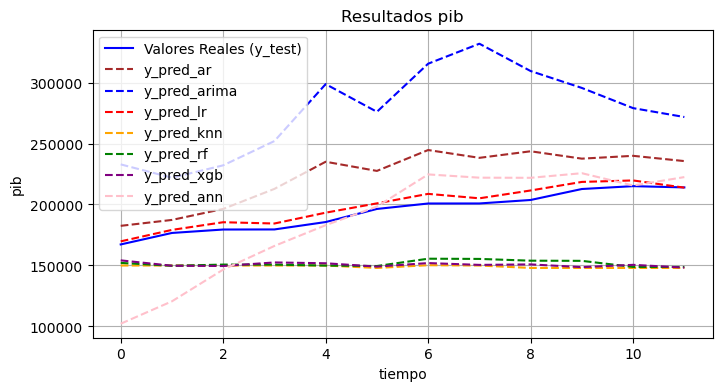

In [ ]:
def plot_comparison(results, target_var):
    colors = {'ar' : 'brown',
              'arima' : 'blue',
              'lr' : 'red',
              'knn' : 'orange',
              'rf' : 'green',
              'xgb' : 'purple',
              'ann' : 'pink'}
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test.values, label="Valores Reales (y_test)", color="blue")
    
    for name, result in results.items():
        if name in ('ar', 'arima'):
            plt.plot(result['y_pred'].reset_index(drop=True), label=f"y_pred_{name}", color=colors[name], linestyle="--")
        else:
            plt.plot(result['y_pred'], label=f"y_pred_{name}", color=colors[name], linestyle="--")

    plt.xlabel("tiempo")
    plt.ylabel(target_var)
    plt.title(f"Resultados {target_var}")
    plt.legend()
    plt.grid()
    plt.savefig(f'result_{target_var}.png', dpi=300)
    plt.show()

plot_comparison(results, target_var)